In [1]:
import jax
import jax.numpy as jnp
from jax import jit
import numpy as np
import optax
from flax.training import train_state
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from soap_jax import soap
import jaxmetric as jm
import models

In [2]:
# key = jax.random.PRNGKey(0)

# psi=0

# k_mod = [1]

# proj_facts = (4,)

# poly = jit(lambda x: x[0]**5 + x[1]**5 + x[2]**5 +x[3]**5 + x[4]**5 + psi* x[0]*x[1]*x[2]*x[3]*x[4])

proj_facts = (1,1,1,1)
k_mod = [1,1,1,1]

psi0 = 0.5
psi1 = 1.

import itertools
combinations = list(itertools.product([0, 1], repeat=4))



@jit
def poly(x):
    X = jnp.array([x[0],x[1]])
    Y = jnp.array([x[2],x[3]])
    U = jnp.array([x[4],x[5]])
    V = jnp.array([x[6],x[7]])
    term_sum = 0
    term_prod = psi1 * (X[0] * Y[0] * U[0] * V[0]) * (X[1] * Y[1] * U[1] * V[1])
    for c in combinations:
        s = sum(c)
        term_sum += (1-s%2)*(X[c[0]] * Y[c[1]] * U[c[2]] * V[c[3]])**2. + psi0*(s%2)*(X[c[0]] * Y[c[1]] * U[c[2]] * V[c[3]])**2.

    return term_prod + term_sum

In [3]:
# points = jm.point_gen.generate_points_calabi_yau(key, proj_facts,poly,5e5)


# with open("500kPointsPsiEq0.pkl", "wb") as f:
#     pickle.dump(points, f)


# with open("cyMetPoints100kQuintic.pkl", "rb") as f:
#     points = pickle.load(f)

with open("100kPointsTQ.pkl", "rb") as f:
    points = pickle.load(f)

print(jnp.shape(points))

(100000, 8)


In [8]:
# Initialize the model
model = models.FuncTQ()

# Generate a PRNG key
key = jax.random.PRNGKey(np.random.randint(0,10**6))

# Initialize parameters
params = model.init(key,  jm.complex_numbers.complex_to_real(points[1]))

kappa_val = jm.metrics.kappa(proj_facts,k_mod, poly, points)

print(kappa_val)

(0.03060762-1.4643181e-10j)


In [9]:
# Split points into training and evaluation sets
split_ratio = 0.8
split_index = int(len(points) * split_ratio)
train_points = points[:split_index]
eval_points = points[split_index:]

def batch_data(data, batch_size):
    num_batches = len(data) // batch_size
    return jnp.array_split(data[:num_batches * batch_size], num_batches)

ptsBatched = batch_data(train_points, 64)

print(ptsBatched[0].shape,len(ptsBatched))
print(eval_points[0].shape,len(eval_points))

(64, 8) 1250
(8,) 20000


In [ ]:
scals = [jm.metrics.ricci_scalar(model, params, proj_facts, k_mod, poly, ptsBatched[n]).real for n in tqdm(range(100))]
scals = jnp.array(scals).flatten()

  0%|          | 0/100 [00:00<?, ?it/s]

(array([329., 694., 571., 535., 836., 819., 710., 490., 398., 292., 236.,
        145., 104.,  58.,  38.,  24.,  23.,  20.,  12.,  10.,   7.,   9.,
          2.,   4.,   4.,   2.,   2.,   1.,   4.,   2.,   2.,   5.,   0.,
          2.,   0.,   3.,   0.,   1.,   2.,   2.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.]),
 array([-18.40808487, -15.27660179, -12.14511871,  -9.01363564,
         -5.88215208,  -2.75066876,   0.38081452,   3.51229763,
          6.64378119,   9.77526379,  12.90674782,  16.0382309 ,
         19.16971397,  22.30119705,  25.43268013,  28.56416321,
         31.69564629,  34.82712936,  37.95861435,  41.09009552,
         44.22158051,  47.35306168,  50.48454666,  53.61602783,
         56.74751282,  59.8789978 ,  63.01047897,  66.14196014,
         69.27344513,  72.40493011,  75.5364151 ,  78.66789246,
         81.79937744,  84.93086243,  88.06234741,  91.19382477,
         94.32530975,  97.45679474, 100.58827972, 103.71976471,
        106.851242

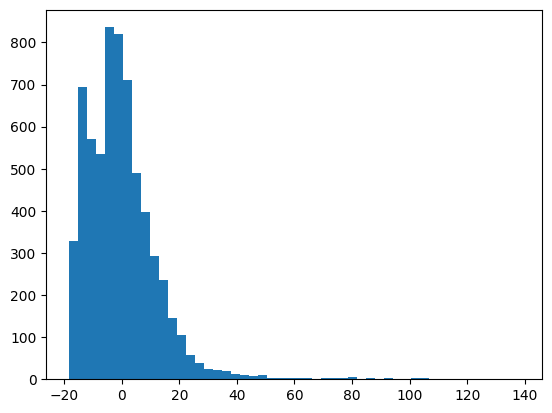

In [7]:
plt.hist(scals,bins=50)

In [6]:
def replace_nan_grads(gradients, replacement_value=1e-8):
    def replace(grad):
        return jnp.where(jnp.isnan(grad), replacement_value, grad)
    
    return jax.tree_util.tree_map(replace, gradients)

def nan_replacement_transform(replacement_value=1e-6):
    def init_fn(params):
        return ()
    
    def update_fn(updates, state, params=None):
        sanitized_updates = jax.tree_util.tree_map(
            lambda g: jnp.where(jnp.isnan(g), replacement_value, g),
            updates
        )
        return sanitized_updates, state
    
    return optax.GradientTransformation(init_fn, update_fn)

optimiser = optax.chain(
#optax.clip(1),
soap(learning_rate=1e-3),
#optax.clip_by_block_rms(1e-2),
#optax.adam(learning_rate=1e-3),
#nan_replacement_transform(1e-8)
)

my_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimiser)

grad_func = jax.jit(jax.value_and_grad(jm.losses.loss_ma,argnums=1),static_argnums=(0,2,4))

# Define the training step
@jax.jit
def train_step(state,x):
  loss, grads = grad_func(model, state.params,proj_facts,k_mod, poly,  kappa_val, x)
  state = state.apply_gradients(grads=grads)
  return state, loss

@jax.jit
def evaluate_step(state,x,scalar_num=100):
  loss = jm.losses.loss_ma(model, state.params,proj_facts,k_mod, poly, kappa_val, x)
  scalar =  jnp.mean(jnp.abs(jm.metrics.ricci_scalar(model, state.params, proj_facts, k_mod, poly, x[:scalar_num])))
  return loss, scalar

@jax.jit
def evaluate_step_simple(state,x):
  loss = jm.losses.loss_ma(model, state.params,proj_facts,k_mod, poly, kappa_val, x)
  return loss

In [7]:
kappa_val

Array(0.03060762-1.4643181e-10j, dtype=complex64)

In [8]:
proj_facts

(1, 1, 1, 1)

In [9]:
pt_r = jax.vmap(jm.complex_numbers.complex_to_real)(points[:1])

In [12]:
jm.metrics.cy_metric_amb_real(model, params, proj_facts, k_mod,pt_r).shape

(1, 2, 8, 8)

In [13]:
jm.metrics.cy_metric(model, my_state.params, proj_facts, k_mod, poly, points[:1])

Array([[[ 0.16659856+0.0000000e+00j, -0.00345058-8.7595312e-05j,
          0.01451402-5.2007525e-03j],
        [-0.00345058+8.7595545e-05j,  0.10259634-1.1641532e-10j,
         -0.01851901-2.3209387e-03j],
        [ 0.01451402+5.2007525e-03j, -0.01851901+2.3209383e-03j,
          0.1813351 -4.6566129e-10j]]], dtype=complex64)

In [14]:
jm.metrics.get_ref_metric(proj_facts, k_mod, poly, points[:1])

Array([[[ 0.16372317+0.0000000e+00j, -0.00725359+3.6366559e-03j,
          0.01193481+1.9854982e-04j],
        [-0.00725359-3.6366559e-03j,  0.09886518-2.9103830e-10j,
         -0.00678645-3.5449218e-03j],
        [ 0.01193481-1.9855006e-04j, -0.00678645+3.5449218e-03j,
          0.16981006-1.1641532e-09j]]], dtype=complex64)

In [ ]:
# Train the model
# eval, scal = evaluate_step(my_state,eval_points)
eval = evaluate_step_simple(my_state,eval_points)
loss = []
lossEval = [[0,eval]]
#sigma = [[0,sig]]
#scalar = [[0,scal]]
pbar = tqdm(range(10))
batchNum = len(ptsBatched)
pbar.set_description(f"Last Eval Loss {eval} | Batch {0}/{batchNum+1}  | Batch Loss: NA")

for i in pbar:
  order = np.array(range(batchNum))
  np.random.shuffle(order)
  k=1
  for j in order:
    k+=1
    my_state, l = train_step(my_state, ptsBatched[j])
    if k % 10 == 0:
      pbar.set_description(f"Last Eval Loss {eval} | Batch {k}/{batchNum+1}  | Batch Loss: {l}" )
    loss.append(l)
  # eval, scal = evaluate_step(my_state,eval_points)
  eval = evaluate_step_simple(my_state,eval_points)
  lossEval.append([(i+1)*batchNum,eval])
  # scalar.append([(i+1)*batchNum,scal])

Last Eval Loss 0.1367424726486206 | Batch 350/1251  | Batch Loss: 0.13462179899215698:  10%|█         | 1/10 [02:56<22:42, 151.41s/it] 

In [12]:
lossEval=jnp.array(lossEval)
loss = jnp.array(loss)
# scalar = jnp.array(scalar)

In [14]:
lossEval[:5]

Array([[   0.,   nan],
       [1250.,   nan],
       [2500.,   nan],
       [3750.,   nan]], dtype=float32)

In [ ]:
plt.plot(loss, label='Training Loss')
plt.plot(lossEval[:,0], lossEval[:,1], label='Evaluation Loss')
# plt.plot(scalar[:,0], scalar[:,1], label='Scalar')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 640x480 with 1 Axes>

In [11]:
scals = [jm.metrics.ricci_scalar(model, my_state.params, proj_facts, k_mod, poly, ptsBatched[n]).real for n in tqdm(range(100))]
scals = jnp.array(scals).flatten()

100%|██████████| 100/100 [02:32<00:00,  1.52s/it]


(array([1.000e+00, 1.000e+00, 4.000e+00, 8.000e+00, 2.700e+01, 8.200e+01,
        3.030e+02, 6.970e+02, 1.220e+03, 1.498e+03, 1.249e+03, 7.150e+02,
        3.430e+02, 1.470e+02, 4.900e+01, 2.500e+01, 1.200e+01, 6.000e+00,
        3.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-2.80934811, -2.5154078 , -2.22146773, -1.92752743, -1.63358724,
        -1.33964705, -1.04570675, -0.75176656, -0.45782635, -0.16388613,
         0.13005409,  0.4239943 ,  0.71793455,  1.01187479,  1.30581498,
         1.59975517,  1.89369535,  2.18763566,  2.48157597,  2.77551603,
         3.06945634,  3.36339641,  3.65733671,  3.95127702,  4.24521732,
         4.

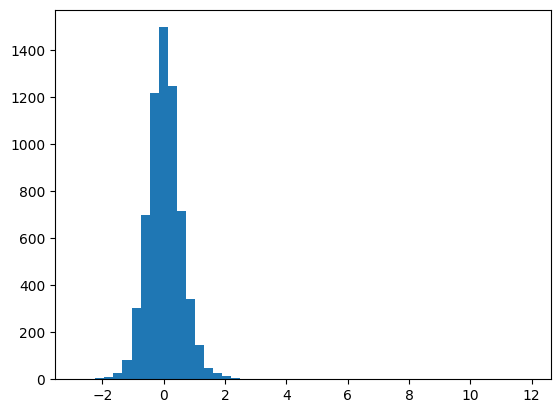

In [12]:
plt.hist(scals,bins=50)